# Dataset Creation

Package for creating synthetic PIV images:

In [2]:
import synpivimage as spi 
spi.__version__

'0.1.9'

In [3]:
import h5rdmtoolbox as h5tbx
h5tbx.__version__

'0.1.15'

For the notebook we retrieve the dataset directory from the dot-env file:

In [4]:
from dotenv import load_dotenv
import os
import numpy as np

load_dotenv('generation.env')
dataset_dir = os.getenv('dataset_dir')
dataset_dir

'example_data_dir'

## 1. Define an inital configuration
The initial configuration shall be the default one of the synpivimage package. From there, we adjust the parameters.<br>
Note, that the image width/height is chosen to be odd. This is recommended when using the auto-correlation feature later on.<br>
Also note, that the default configuration **disabled noise generation** since it always can be added afterwards. 

In [5]:
cfg = spi.DEFAULT_CFG

cfg['bit_depth'] = 8
cfg['nx'] = 32
cfg['ny'] = 32
cfg['sensor_gain'] = 0.6
cfg['particle_size_std'] = 1
image_size = cfg['nx']*cfg['ny']
cfg

{'ny': 32,
 'nx': 32,
 'square_image': True,
 'bit_depth': 8,
 'noise_baseline': 0.0,
 'dark_noise': 0.0,
 'sensitivity': 1,
 'qe': 1,
 'shot_noise': False,
 'particle_number': 1,
 'particle_size_mean': 2.5,
 'particle_size_std': 1,
 'laser_width': 3,
 'laser_shape_factor': 2,
 'sensor_gain': 0.6,
 'particle_position_file': None,
 'particle_size_illumination_dependency': True}

## 2. Defining parameters to be varied

Create tuples with the configuration name and the parameters. The parameter values can be a number only, a list or a numpy array (Obviously passing a number is equal to not specify the variation tuple at all).<br>
Last we specify how many images per combinations will be generated with `n_per_combination`

In [13]:
# particle_number_range = ('particle_number', np.arange(1, image_size*0.1, 10).astype(int))
particle_number_range = ('particle_number', int(0.1*30*30))
particle_mean_size_range = ('particle_size_mean', (2, 3))
lasershape_range = ('laser_shape_factor', (1,10))

n_per_combination = 101

## 3. Generate a list of all config combinations:
Before we can write the data to disk, we generate a `ConfigManager`. This class is initalize by passing a list of all configuration dictionaries that define each image generation. Thus we need 101 configuration dictionaries. Using `build_ConfgManger()` we retrieve the `ConfigManger`-instance by passing the inital config dictionary and the variation tuples from above (so we don't need to deal with building the man config dictionaries ourselves):

In [14]:
CFGs = spi.build_ConfigManager(cfg, [particle_number_range,
                                     particle_mean_size_range,
                                     lasershape_range],
                              per_combination = n_per_combination,
                              shuffle=True)
CFGs

Configurations with 404 configurations

## 4. Write all data to HDF5 files:
With a large amount of parameters the image generation may produce arrays that will blow your RAM. Therefore define the maximal number of images to be created before written to the file. This parameter is called `n_split`. If using `None`, all data is written into a single file. If you pass any integer number, then that number of files will be created. Filenames will look like `<dataset_dir>/ds_000001.hdf` and so on.

In [15]:
%%time
hdf_filename = CFGs.to_hdf(dataset_dir, nproc=1, n_split=1000, overwrite=True)

Writing 404 dataset into 1 HDF5 file(s). This may take a while...


  0%|                                                                                    | 0/404 [00:00<?, ?cfg dict/s]c:\users\da4323\documents\programming\git\dev\synpivimage\synpivimage\core.py:170: UserWarning: Particles smaller then 0.1 are set to 0.1.
  warnings.warn(f'Particles smaller then {PMIN_ALLOWED} are set to {PMIN_ALLOWED}.')
100%|█████████████████████████████████████████████████████████████████████████| 404/404 [00:02<00:00, 171.51cfg dict/s]


... done.
CPU times: total: 2.5 s
Wall time: 2.46 s


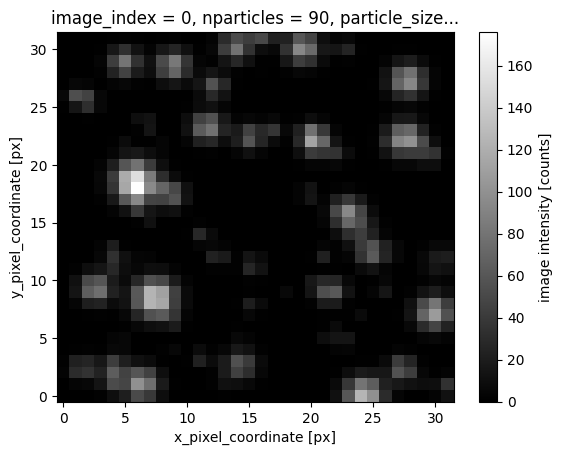

In [16]:
import h5rdmtoolbox as h5tbx
import matplotlib.pyplot as plt

with h5tbx.H5File(hdf_filename[0], 'r') as h5:
    h5.dump()
    h5['images'][0, :, :].plot(cmap='gray')

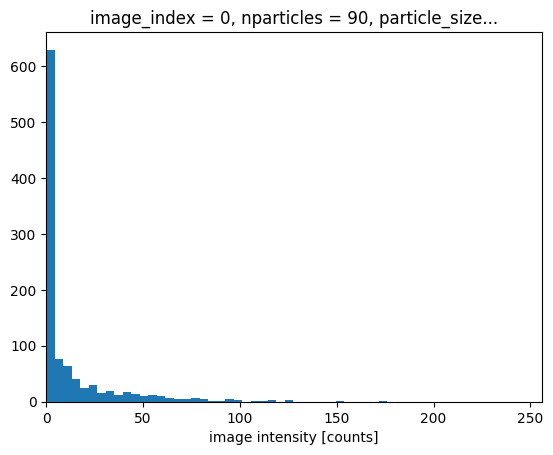

In [17]:
import h5rdmtoolbox as h5tbx
import matplotlib.pyplot as plt

with h5tbx.H5File(hdf_filename[0], 'r') as h5:
    h5['images'][0, :, :].plot.hist(bins=40, xlim=[0, 2**8], xscale='linear', yscale='linear')